#### **진행 순서**   
numberical features -> percentile with logreg -> 41features   
BOW + 41features -> AE -> DNN   

libraries

In [1]:
# basic 

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50, 'display.max_rows', 200)
from itertools import combinations
import os

# plot

import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)


# models
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile
from scipy.stats.mstats import gmean
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ShuffleSplit

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from bayes_opt import BayesianOptimization
from sklearn.ensemble import VotingClassifier
from vecstack import StackingTransformer
from vecstack import stacking

%run import_modules.py  
%matplotlib inline

# For DNN modeling
import tensorflow as tf

# Tensorflow warning off
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#  tf.logging.set_verbosity(tf.logging.ERROR) <- logging이 버전업그레이드에서 사용 X라함

# from tensorflow import set_random_seed 
# 위에 코드 안됨에 대한 답변: In Tensoflow2 there is no need to perform
# from tensorflow import set_random_seed
# in order to run
# set_random_seed(x)
# (as it was in older version)
# Only have to run
# import tensorflow
# tensorflow.random.set_seed(x)

tf.random.set_seed(2020)
import keras
from keras import backend as K
from keras.layers import * #Input, Dense
from keras.models import * #Model
from keras.optimizers import *
from keras.initializers import *
from keras.regularizers import *
from keras.utils.np_utils import *
from keras.utils.vis_utils import * #model_to_dot

ImportError: cannot import name 'joblib' from 'sklearn.externals' (C:\Users\82105\anaconda3\lib\site-packages\sklearn\externals\__init__.py)

Using TensorFlow backend.


### Read Data(1)

In [27]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()

Extract numberical 41 Features from Percentile(by logreg)

In [18]:
X_train_41 = pd.read_csv('X_train_after_preprocessing41.csv', encoding ='cp949')
X_test_41 = pd.read_csv('X_test_after_preprocessing41.csv', encoding ='cp949')

transform categorical data using BOW

In [19]:
level = 'gds_grp_nm'

df_all = pd.concat([df_train, df_test])
train1 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test1 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values

level = 'gds_grp_mclas_nm'

df_all = pd.concat([df_train, df_test])
train2 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test2 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values

level = 'goods_id'

df_all = pd.concat([df_train, df_test])
train3 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test3 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values

train = np.hstack([train1, train2, train3])
test = np.hstack([test1, test2, test3])

train.shape, test.shape

((3500, 4179), (2482, 4179))

In [20]:
train_ae = pd.DataFrame(train)
test_ae = pd.DataFrame(test)

In [21]:
train = pd.concat([X_train_41, train_ae], axis=1)
test = pd.concat([X_test_41, test_ae], axis=1)
train.shape, test.shape

((3500, 4220), (2482, 4220))

In [22]:
train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,4154,4155,4156,4157,4158,4159,4160,4161,4162,4163,4164,4165,4166,4167,4168,4169,4170,4171,4172,4173,4174,4175,4176,4177,4178
0,0.982094,-0.504664,1.123974,0.371957,-0.769916,0.662100,-0.284093,-0.877708,0.064286,0.275346,0.647643,-0.085274,0.015177,0.110992,-0.704409,0.424851,-0.404948,0.300900,-0.423406,0.535673,0.163501,-0.497108,-0.070671,-0.405971,0.304297,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-1.215208,-0.017400,-0.465950,-0.046479,-0.195007,-0.175801,0.256942,-0.282640,0.082884,-0.381074,-0.034089,0.193551,0.474283,-0.565206,0.309148,0.174981,-0.123788,-0.309818,0.010033,-0.166877,-0.024879,0.026302,0.424455,0.304623,0.336566,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-1.480931,-0.081367,-0.076139,0.131531,-0.088417,-0.174095,-0.293022,-0.022966,0.687783,-0.472720,0.462877,0.289197,-0.607224,0.080766,0.000761,-0.408717,0.282798,-0.199497,-0.286557,0.519733,-0.110728,0.237649,0.275522,-0.170139,-0.018502,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.048247,-0.668469,-0.386952,-0.114146,0.504008,0.544103,0.669133,0.739678,0.615703,0.362655,-0.202718,0.972889,-0.450911,-0.453425,0.172811,-0.502450,0.569078,0.613191,0.521050,-0.171620,0.346603,-0.113566,-0.066143,0.101673,-0.090840,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-1.085032,0.444800,0.431179,-0.014417,-0.395529,-0.196057,-0.019694,0.084428,-0.385758,0.130159,-0.299835,0.547423,-0.426956,-0.282172,-0.143346,-0.197925,-0.062057,-0.105541,0.180664,-0.115687,-0.031676,-0.158333,0.248115,0.117931,0.602348,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,-1.354330,0.428018,-0.431697,0.371755,0.059029,0.139992,-0.047427,0.054583,0.555799,-0.109492,0.135317,0.052686,0.167169,-0.486498,-0.052368,0.035836,-0.209156,-0.381021,0.075340,-0.095592,0.019032,-0.248754,-0.061996,-0.131704,-0.186288,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3496,-0.740669,-0.950728,0.132437,0.156816,-0.762689,-0.206158,0.318618,0.070968,-0.238573,0.207345,-0.103906,0.304509,-0.667569,-0.067443,-0.619240,-0.039136,0.156531,-0.040675,0.292115,-0.019906,-0.478802,0.512053,-0.657195,0.007106,0.167556,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3497,-1.786170,0.104859,-0.208584,-0.229384,0.199843,-0.465180,-0.238409,0.061877,0.507629,-0.118682,0.466909,-0.543505,0.324437,0.056039,-0.113526,-0.225544,-0.047234,0.049549,-0.011020,0.173778,0.022927,-0.061245,-0.143256,-0.099148,-0.176865,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3498,-1.451272,0.565601,0.305481,-0.476851,0.279872,0.389127,-0.246900,-0.057624,-0.201262,0.332502,0.379351,-0.507074,0.021633,0.009679,0.131716,-0.270933,-0.159663,0.392186,-0.129043,0.023872,-0.472576,-0.293708,-0.045724,-0.118339,-0.145411,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,4154,4155,4156,4157,4158,4159,4160,4161,4162,4163,4164,4165,4166,4167,4168,4169,4170,4171,4172,4173,4174,4175,4176,4177,4178
0,0.176937,-0.583826,-0.939580,0.467606,-1.022492,0.364910,-0.662706,0.943723,-0.601764,-0.169561,0.111299,0.171366,-0.285847,0.548978,0.278592,0.212268,-0.141882,-0.015572,0.365503,0.337017,-0.139248,-0.636076,-0.303149,0.685805,0.046585,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.012790,-0.194273,-0.409589,0.243464,0.691517,-0.469563,0.077997,-1.163428,-0.156748,0.337713,-1.232221,0.015095,-0.248615,0.129277,-0.019365,0.100514,-0.265536,0.151192,0.495951,0.015403,0.120114,0.304504,0.129763,0.313189,0.176262,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4.018016,1.173423,0.004245,-0.055749,0.429428,-0.034507,-0.119664,0.538039,0.150951,-0.469155,0.322665,0.117449,0.255193,0.064267,-0.500125,-0.741651,-0.473586,0.631463,-0.323819,-0.090220,-0.449775,0.553408,0.009146,-0.046049,0.404814,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
3,-0.942564,0.080067,0.005766,-0.894329,-0.460378,-0.094914,-0.436508,-0.519387,0.495334,0.101024,0.438507,-0.195275,-0.243280,0.810783,0.178303,0.514736,-0.049327,0.710599,-0.419928,0.446321,-0.539978,0.322046,0.302080,0.512945,0.300451,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-1.190258,0.335129,-0.119073,0.071123,-0.108039,-0.334674,0.081188,0.132353,0.395933,0.233305,0.764636,0.067923,-0.297054,0.809404,0.021642,0.371044,-0.080503,0.340837,-0.328768,0.258588,-0.330861,0.148829,0.225990,0.322900,0.329864,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477,-0.257353,-0.350982,-0.494630,0.098872,-0.668433,-0.503620,0.103689,-0.212455,-0.231185,-0.195961,0.231894,-0.249089,0.068212,0.555360,-0.312592,0.383768,0.489289,0.389829,-0.235873,0.087173,0.530278,-0.124932,-0.331023,0.340765,0.025653,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2478,-1.558696,0.017406,0.058093,0.073737,0.225678,-0.314287,-0.705368,-0.169173,0.924773,-0.258874,0.382855,-0.428141,-0.447757,-0.027075,0.161380,0.177850,-0.086882,0.148974,0.068542,-0.528279,-0.151528,-0.048019,0.311375,-0.110428,-0.023620,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2479,1.205817,0.329429,-1.201388,1.287096,0.313697,-0.660860,-0.639454,0.847918,-0.290314,-0.007938,-0.984161,-0.468520,0.619928,0.462924,0.382973,0.074684,0.119413,0.544641,-0.067232,0.259945,-0.278348,-0.389207,0.317828,0.247029,-0.194217,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2480,-0.071931,1.101739,0.218091,0.630052,0.435355,-0.359865,-0.307210,0.612636,0.067174,0.010140,-0.139360,0.733693,-0.473812,-0.132638,-0.253039,-0.323561,0.295777,0.299153,-0.036013,-0.145393,-0.134091,-0.179114,0.011012,0.106746,-0.062789,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### DAE feature extraction






  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

DNN learning curve 1/10


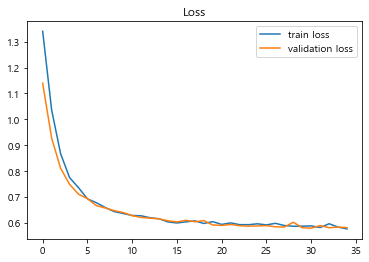






 10%|████████▎                                                                          | 1/10 [01:16<11:26, 76.27s/it]

AUC 0.7708405880804152
DNN learning curve 2/10


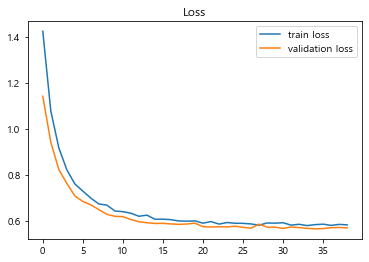






 20%|████████████████▌                                                                  | 2/10 [02:32<10:10, 76.34s/it]

AUC 0.7613713692203002
DNN learning curve 3/10


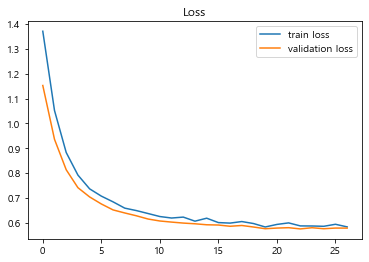






 30%|████████████████████████▉                                                          | 3/10 [03:47<08:51, 75.96s/it]

AUC 0.7665557075151171
DNN learning curve 4/10


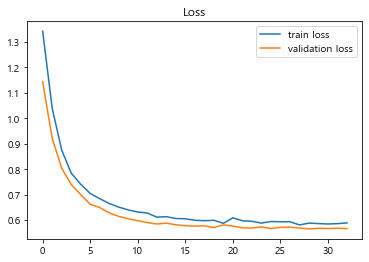






 40%|█████████████████████████████████▏                                                 | 4/10 [05:04<07:36, 76.14s/it]

AUC 0.7735800165837479
DNN learning curve 5/10


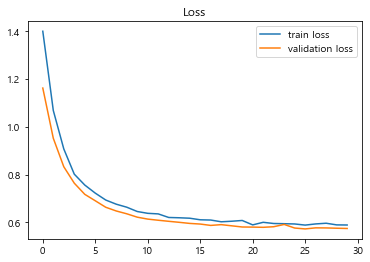






 50%|█████████████████████████████████████████▌                                         | 5/10 [06:20<06:20, 76.16s/it]

AUC 0.7567887807164142
DNN learning curve 6/10


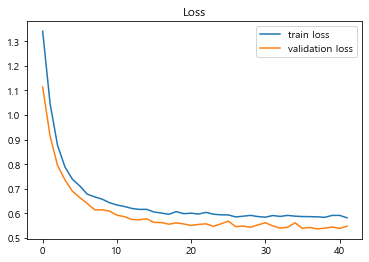

AUC 0.7935162717670569







 60%|█████████████████████████████████████████████████▊                                 | 6/10 [07:39<05:07, 76.84s/it]

DNN learning curve 7/10


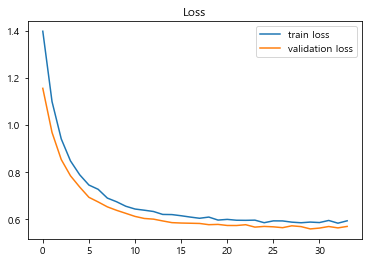






 70%|██████████████████████████████████████████████████████████                         | 7/10 [09:04<03:57, 79.28s/it]

AUC 0.7581901886926865
DNN learning curve 8/10


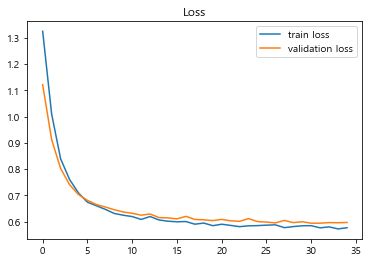






 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [10:31<02:43, 81.63s/it]

AUC 0.7676435106062129
DNN learning curve 9/10


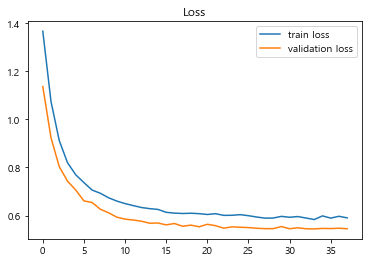






 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [12:03<01:24, 84.79s/it]

AUC 0.7857332418210935
DNN learning curve 10/10


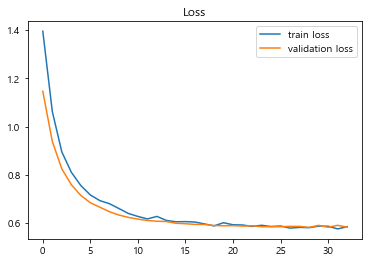






100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [13:29<00:00, 80.97s/it]

AUC 0.7477578475336324

Validation Summary:
5    0.793516
8    0.785733
3    0.773580
0    0.770841
7    0.767644
2    0.766556
1    0.761371
6    0.758190
4    0.756789
9    0.747758
dtype: float64
mean=0.76820, std=0.014


In [29]:
# Set hyper-parameters for power mean ensemble 
# 한번돌릴때마다 13분정도 걸림
N = 10
p = 3.5
preds = []
aucs = []

for i in tqdm(range(N)):    
    X_train, X_test = train, test

    ##### STEP 1: Randomize Seed
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)

    ##### STEP 2: Build DAE #####
    
    # Define the encoder dimension
    encoding_dim = 128

    # Input Layer
    input_dim = Input(shape = (X_train.shape[1], ))

    # Encoder Layers
    noise = Dropout(0.5)(input_dim) # for Denoising
    encoded1 = Dense(512, activation = 'relu')(noise)
    encoded2 = Dense(256, activation = 'relu')(encoded1)
    encoded3 = Dense(128, activation = 'relu')(encoded2)
    encoded4 = Dense(encoding_dim, activation = 'relu')(encoded3)

    # Decoder Layers
    decoded1 = Dense(128, activation = 'relu')(encoded4)
    decoded2 = Dense(256, activation = 'relu')(decoded1)
    decoded3 = Dense(512, activation = 'relu')(decoded2)
    decoded4 = Dense(X_train.shape[1], activation = 'linear')(decoded3)

    # Combine Encoder and Deocder layers
    autoencoder = Model(inputs = input_dim, outputs = decoded4)

    # Compile the model
    autoencoder.compile(optimizer = 'adam', loss = 'mse')

    # Train the model
    history = autoencoder.fit(X_train, X_train, epochs=20, batch_size=64, 
                              shuffle=True, validation_data=(X_test,X_test), verbose=0)

#     print(f'DAE learning curve {i+1}/{N}')
#     plt.plot(history.history["loss"], label="train loss")
#     plt.plot(history.history["val_loss"], label="validation loss")
#     plt.legend()
#     plt.title("Loss")
#     plt.show()

    ##### STEP 3: Reduce Dimension #####
        
    # Use a middle Bottleneck Layer to Reduce Dimension
    model = Model(inputs=input_dim, outputs=encoded4)
    X_train = model.predict(X_train)
    X_test = model.predict(X_test)

    
    ##### STEP 4: Build a DNN Model

    # Define the Model architecture
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.015)))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Train the Model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2)
    history = model.fit(train_x, train_y, epochs=50, batch_size=64, 
                        validation_data=(valid_x,valid_y), callbacks=[tf.keras.callbacks.EarlyStopping(patience=4)], verbose=0)

    print(f'DNN learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()
    
    # Make Prediction
    auc = roc_auc_score(valid_y, model.predict(valid_x).flatten())
    aucs.append(auc)
    print('AUC', auc)
    preds.append(model.predict(X_test).flatten())   

### Validate the Models
print('\nValidation Summary:')
aucs = pd.Series(aucs)
print(aucs.sort_values(ascending=False))
print('mean={:.5f}, std={:.3f}'.format(aucs.mean(), aucs.std()))   

percentile41만 돌려보기






  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

DNN learning curve 1/10


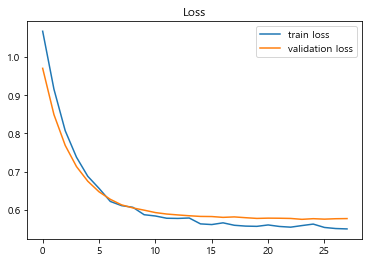






 10%|████████▎                                                                          | 1/10 [00:02<00:24,  2.76s/it]

AUC 0.7612159438420906
DNN learning curve 2/10


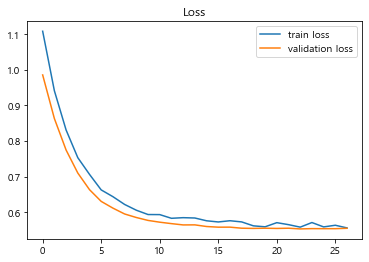






 20%|████████████████▌                                                                  | 2/10 [00:05<00:21,  2.69s/it]

AUC 0.7869281382161946
DNN learning curve 3/10


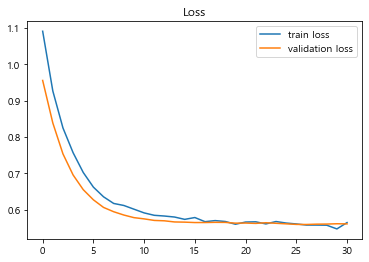






 30%|████████████████████████▉                                                          | 3/10 [00:08<00:20,  2.92s/it]

AUC 0.7722755555555556
DNN learning curve 4/10


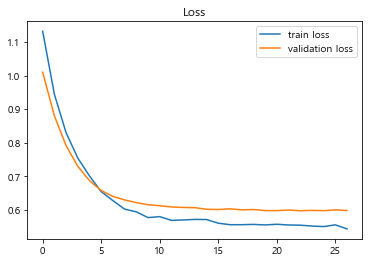






 40%|█████████████████████████████████▏                                                 | 4/10 [00:11<00:17,  2.98s/it]

AUC 0.7405104120971279
DNN learning curve 5/10


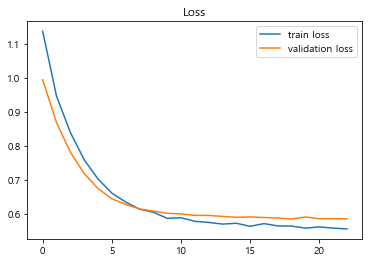






 50%|█████████████████████████████████████████▌                                         | 5/10 [00:14<00:14,  2.83s/it]

AUC 0.7344483247844593
DNN learning curve 6/10


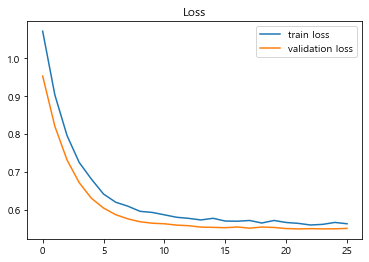






 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:17<00:11,  2.78s/it]

AUC 0.780264243693378
DNN learning curve 7/10


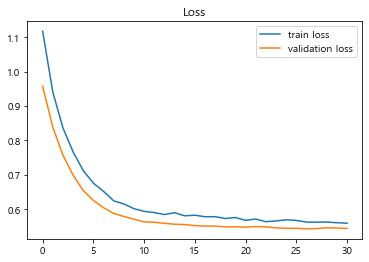






 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:20<00:09,  3.00s/it]

AUC 0.7793959446388052
DNN learning curve 8/10


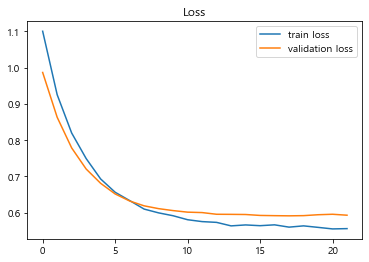






 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:23<00:05,  2.87s/it]

AUC 0.75253739202813


In [ ]:
# Set hyper-parameters for power mean ensemble 
# 한번돌릴때마다 13분정도 걸림
N = 10
p = 3.5
preds = []
aucs = []

for i in tqdm(range(N)):    
    X_train, X_test = X_train_41, X_test_41

    ##### STEP 1: Randomize Seed
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)

    
    ##### STEP 4: Build a DNN Model

    # Define the Model architecture
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Train the Model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2)
    history = model.fit(train_x, train_y, epochs=50, batch_size=64, 
                        validation_data=(valid_x,valid_y), callbacks=[tf.keras.callbacks.EarlyStopping(patience=4)], verbose=0)

    print(f'DNN learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()
    
    # Make Prediction
    auc = roc_auc_score(valid_y, model.predict(valid_x).flatten())
    aucs.append(auc)
    print('AUC', auc)
    preds.append(model.predict(X_test).flatten())   

### Validate the Models
print('\nValidation Summary:')
aucs = pd.Series(aucs)
print(aucs.sort_values(ascending=False))
print('mean={:.5f}, std={:.3f}'.format(aucs.mean(), aucs.std()))   